# Analysis of accuracy and speed of stochastic simulation libraries

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pathlib

sns.set_style("whitegrid")

---
## Functions

In [2]:
def make_accuracy_df(filename: str, use_ratio_for_approx=True):
    """ Compile all accuracy results into a pandas dataframe """
    full_algos = ["direct"]
    approx_algos = ["tau_leaping", "tau_adaptive"]
    df  = pd.read_csv(filename, dtype={"model":str})
    df.loc[:, "nspecies"] = 1
    df.loc[df.model.isin(["00030", "00031"]), "nspecies"] = 2
    df.loc[:, "ntest"] = df.nspecies * 100 # number of tests
    # Number passing should be ntest
    full_inds = df.algo.isin(full_algos)
    approx_inds = df.algo.isin(approx_algos)
    if use_ratio_for_approx:
        df.loc[full_inds, "total_pass"] = (df[full_inds].ntest - 
                                           (df.loc[full_inds, "test0"] + 
                                            df.loc[full_inds, "test1"] + 
                                            df.loc[full_inds, "test2"] + 
                                            df.loc[full_inds, "test3"]))/df[full_inds].ntest * 100

        df.loc[approx_inds, "total_pass"] = (df[approx_inds].ntest - 
                                           (df.loc[approx_inds, "rtest0"] + 
                                            df.loc[approx_inds, "rtest1"] + 
                                            df.loc[approx_inds, "rtest2"] + 
                                            df.loc[approx_inds, "rtest3"]))/df[approx_inds].ntest * 100
    else:
        df.loc[:,"total_pass"] = (df.ntest - (df["test0"] + 
                                              df["test1"] + 
                                              df["test2"] + 
                                              df["test3"]))/df.ntest * 100
    # If test0 is -1 because test didn't ocmplete, then they should be labeled as such.
    df.loc[df["total_pass"] > df.ntest, "total_pass"] = -0.1
    return df

In [3]:
def make_benchmark_df(path):
    """ Compile all benchmark results into a pandas dataframe """
    files = list(pathlib.Path(path).glob("*.json"))
    results = []
    for this_file in files:
        with open(this_file) as fid:
            data_dict = json.load(fid)
            lib, algo, model, nreps = this_file.stem.split("-")
            this_result = data_dict["results"][0]
            this_result["lib"] = lib
            this_result["algo"] = algo
            this_result["model"] = model
            this_result["nrep"] = int(nreps)
            results.append(this_result)
    df = pd.DataFrame(results)
    df = df[df.nrep == 10000]
    return df

In [35]:
LIB_PALETTE = {"pyssa":current_palette[1], "BioSimulator":current_palette[0],
               "BioSimulatorIntp":current_palette[2], "GillespieSSA":current_palette[3],
               "Tellurium":current_palette[4]}
ALGO_PALETTE = {"direct":current_palette[1], "tau_leaping":current_palette[0],
                       "tau_adaptive":current_palette[2]}

def plot_accuracy_barplot(df, hue="algo"):
    """ Plot a barplot of total success for each test in the df """
    plt.figure(figsize=(14,5))
    if hue == "lib":
        current_palette = sns.color_palette("Set1", n_colors=5)
        libs = set(df["lib"])
        new_palette = {key: value for key, value in LIB_PALETTE.items() if key in libs}
        g = sns.barplot(x="model", y="total_pass", hue=hue, data=df, palette=new_palette,
                       hue_order=reversed(sorted(new_palette.keys())))
    elif hue == "algo":
        current_palette = sns.color_palette("Set1", n_colors=3)
        algos = set(df["algo"])
        new_palette = {key: value for key, value in ALGO_PALETTE.items() if key in algos}
        g = sns.barplot(x="model", y="total_pass", hue=hue, data=df, palette=new_palette,
                       hue_order=reversed(sorted(new_palette.keys())))
    else:
        g = sns.barplot(x="model", y="total_pass", hue=hue, data=df)
    two_sp_models = ["00030", "00031"]
    for p in g.patches:
        if np.isnan(p.get_height()):
            continue
        if p.get_height() < 0:
            color = "blue"
            height="dnf"
        else:
            height = int(p.get_height())
            if height == 100:
                color = "green"
            else:
                color = "red"
        g.annotate(f"{height}", (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', fontsize=8, color=color, xytext=(0, 10),
        textcoords='offset points')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
    plt.ylabel("Percentage of total pass")
    plt.ylim(-5,120)

In [5]:
def plot_benchmark_barplot(df):
    """ Plot a barplot of time taken for each simulation in the df """
    times = df.explode("times")
    sns.barplot(x="model", y="times", hue="lib", data=times)

---
## Models

To compare the accuracies of the algorithms, we used a subset of the models recommended in the [SBML test suite's stochastic component](https://github.com/sbmlteam/sbml-test-suite/blob/master/cases/stochastic/DSMTS-userguide-31v2.pdf). They consist of 4 systems with different parameter combinations, resulting in a total of 14 models or 14 system-parameter combinations. The systems and parameter combinations are outlined below.

### System 1: Birth-death process

This model involves one species $\mathbf{X}$ and consists of the following reactions:
$$\textit{birth: } \mathbf{X} \xrightarrow{\lambda} 2\mathbf{X} $$
$$\textit{death: } \mathbf{X} \xrightarrow{\mu} \varnothing $$

#### Models

| Model ID | $X[0]$ | $\lambda$ | $\mu$ |
|:--------:|:------:|:---------:|-------|
|   00001  | 100    |    0.1    | 0.11  |
|   00003  | 100    |    1.0    | 1.1   |
|   00004  | 10     |    0.1    | 0.11  |
|   00005  | 10000  |    0.1    | 0.11  |
|   00011  | 100    |    0.0    | 0.055 |

### System 2: Immigration-death process

This model involves one species $\mathbf{X}$ and consists of the following reactions:
$$ \textit{immigration: } \varnothing \xrightarrow{\alpha} \mathbf{X} $$
$$ \textit{death: } \mathbf{X} \xrightarrow{\mu} \varnothing $$

#### Models

| Model ID |$$X[0]$$| $\alpha$ | $\mu$ |
|:--------:|:------:|:--------:|-------|
|   00020  | 0.0    |    1.0   | 0.1   |
|   00021  | 0.0    |   10.0   | 0.1   |
|   00022  | 0.0    |    5.0   | 0.1   |
|   00023  | 0.0    |   1000   | 0.1   |

### System 3: Dimerization

This model involves two species $\mathbf{X}$, $\mathbf{X_2}$ and consists of the following reactions:

$$ \textit{dimerization: } 2\mathbf{X} \xrightarrow{k_1} \mathbf{X_2} $$
$$ \textit{dissociation: } \mathbf{X_2} \xrightarrow{k_2} 2\mathbf{X} $$

>NOTE:
>The dimerization reaction is second order

#### Models

| Model ID |$$X[0]$$|$$X_2[0]$$| $k_1$  | $k_2$ |
|:--------:|:------:|:--------:|--------|-------|
|   00030  | 100    |     0    | 0.001  | 0.01  |
|   00031  | 1000   |     0    | 0.0002 | 0.004 |

### System 4: Batch immigration-death process

This model involves one species $\mathbf{X}$ and consists of the following reactions:
$$ \textit{immigration: } \varnothing \xrightarrow{\alpha} K\mathbf{X} $$
$$ \textit{death: } \mathbf{X} \xrightarrow{\mu} \varnothing $$

#### Models

| Model ID | $$X[0]$$ | $K$ | $\alpha$ | $\mu$ |
|:--------:|:--------:|:---:|:--------:|-------|
|   00037  |    0.0   |  5  |    1.0   | 0.2   |
|   00038  |    0.0   |  10 |    1.0   | 0.4   |
|   00039  |    0.0   | 100 |    1.0   | 4.0   |

---
## Read data

In [15]:
# read accuracy data
pyssa_results = make_accuracy_df("../results/pyssa_results.csv")
tellurium_results = make_accuracy_df("../results/Tellurium_results.csv")
biosimulator_results = make_accuracy_df("../results/BioSimulator_results.csv")
biosimulatorintp_results = make_accuracy_df("../results/BioSimulatorIntp_results.csv")
gillespiessa_results = make_accuracy_df("../results/GillespieSSA_results.csv")
accuracy_results = pd.concat([pyssa_results, tellurium_results, biosimulator_results, biosimulatorintp_results, 
                     gillespiessa_results])
# read benchmark data
benchmark_results = make_benchmark_df("../benchmarks/")

In [16]:
accuracy_results.head()

,model,lib,algo,nrep,test0,test1,test2,test3,rtest0,rtest1,rtest2,rtest3,nspecies,ntest,total_pass
0,00004,pyssa,direct,10000,0,0,0,0,0,0,0,0,1,100,100.0
1,00004,pyssa,tau_adaptive,10000,0,0,0,3,0,0,0,10,1,100,90.0
2,00001,pyssa,direct,10000,0,0,0,0,0,0,0,0,1,100,100.0
3,00001,pyssa,tau_leaping,10000,0,0,0,0,0,0,0,0,1,100,100.0
4,00001,pyssa,tau_adaptive,10000,0,0,0,0,0,0,0,2,1,100,98.0


In [17]:
benchmark_results.head()

,command,mean,stddev,median,user,system,min,max,times,lib,algo,model,nrep
0,python pyssa_test/make_pyssa_results.py 00003 ...,22.109373,1.662900,22.456144,82.576359,1.941489,19.578285,24.217990,"[24.217990215420002, 22.456144158420003, 20.43...",pyssa,tau_adaptive,00003,10000
1,Rscript GillespieSSA_test/make_gillespieSSA_re...,163.526004,2.150417,163.471765,158.476154,5.380983,160.317272,166.633805,"[161.96599679168, 162.68475236768, 165.6347120...",GillespieSSA,tau_leaping,00030,10000
2,julia biosimjl_test/make_biosim_results.jl 000...,6.164676,0.051317,6.162064,6.164080,0.423608,6.084711,6.243738,"[6.210998203105, 6.1357683051050005, 6.1620636...",BioSimulator,tau_adaptive,00021,10000
3,python tellurium_test/make_tel_results.py 0002...,7.517541,0.171825,7.491469,7.577782,0.379616,7.279652,7.848030,"[7.491468931035, 7.848029625035, 7.27965214803...",Tellurium,direct,00021,10000
4,python pyssa_test/make_pyssa_results.py 00001 ...,6.367574,0.807097,6.063183,23.028373,0.566946,5.751014,7.660804,"[7.37642449603, 6.06318282003, 6.17712087803, ...",pyssa,direct,00001,10000


In [18]:
acc_speed_results = benchmark_results.merge(accuracy_results, how="inner", on = ["lib", "algo", "model"])
acc_speed_results.head()

,command,mean,stddev,median,user,system,min,max,times,lib,...,test1,test2,test3,rtest0,rtest1,rtest2,rtest3,nspecies,ntest,total_pass
0,python pyssa_test/make_pyssa_results.py 00003 ...,22.109373,1.662900,22.456144,82.576359,1.941489,19.578285,24.217990,"[24.217990215420002, 22.456144158420003, 20.43...",pyssa,...,3,1,5,0,27,3,12,1,100,58.0
1,Rscript GillespieSSA_test/make_gillespieSSA_re...,163.526004,2.150417,163.471765,158.476154,5.380983,160.317272,166.633805,"[161.96599679168, 162.68475236768, 165.6347120...",GillespieSSA,...,19,0,0,0,0,0,4,2,200,98.0
2,julia biosimjl_test/make_biosim_results.jl 000...,6.164676,0.051317,6.162064,6.164080,0.423608,6.084711,6.243738,"[6.210998203105, 6.1357683051050005, 6.1620636...",BioSimulator,...,1,1,28,0,1,1,30,1,100,68.0
3,python tellurium_test/make_tel_results.py 0002...,7.517541,0.171825,7.491469,7.577782,0.379616,7.279652,7.848030,"[7.491468931035, 7.848029625035, 7.27965214803...",Tellurium,...,0,0,0,0,0,0,0,1,100,100.0
4,python pyssa_test/make_pyssa_results.py 00001 ...,6.367574,0.807097,6.063183,23.028373,0.566946,5.751014,7.660804,"[7.37642449603, 6.06318282003, 6.17712087803, ...",pyssa,...,0,0,0,0,0,0,0,1,100,100.0


---
## Speed vs. accuracy comparison

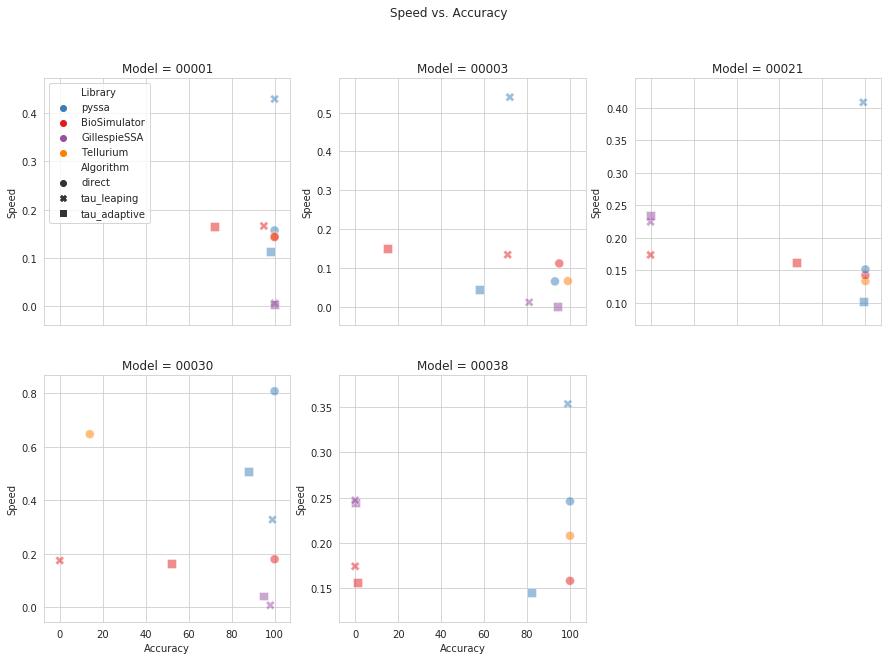

In [26]:
acc_speed_results["Accuracy"] = acc_speed_results["total_pass"]
acc_speed_results["Speed"] = 1/acc_speed_results["mean"]
acc_speed_results["Library"] = acc_speed_results["lib"]
acc_speed_results["Algorithm"] = acc_speed_results["algo"]

models = sorted(set(list(acc_speed_results.model)))
this_filter = (acc_speed_results.model == models[0])
marker_size = 80
fig, ax = plt.subplots(2,3,sharex=True, figsize=([15,10]))
fig.suptitle("Speed vs. Accuracy")
fig.delaxes(ax[1][2])

current_palette = sns.color_palette("Set1", n_colors=5)
new_palette = {"pyssa":current_palette[1], "BioSimulator":current_palette[0],
              "BioSimulatorIntp":current_palette[2], "GillespieSSA":current_palette[3],
              "Tellurium":current_palette[4]}
hue_order = ["pyssa", "BioSimulator", "GillespieSSA", "Tellurium"]
style_order = ["direct", "tau_leaping", "tau_adaptive"]

p = [None] * len(models)
for ind, this_model in enumerate(models):
    this_filter = (acc_speed_results.model == this_model)
    this_ax = ax[ind//3, ind%3]
    this_ax.set_title(f"Model = {this_model}")
    if ind == 0:
        p[ind] = sns.scatterplot(x="Accuracy", y="Speed", hue="Library", style="Algorithm", 
                        data=acc_speed_results[this_filter], s=marker_size,
                        hue_order=hue_order, style_order=style_order, palette=new_palette,
                        ax = this_ax, alpha=0.5)
    else:
        p[ind] = sns.scatterplot(x="Accuracy", y="Speed", hue="Library", style="Algorithm", 
                        data=acc_speed_results[this_filter], s=marker_size,
                        hue_order=hue_order, style_order=style_order, palette=new_palette,
                        ax = this_ax, legend=False, alpha=0.5)

fig.savefig("../assets/acc_speed_comparison_all.png")

In [29]:
this_filter = (acc_speed_results.model == "00001")
p[ind] = sns.scatterplot(x="Accuracy", y="Speed", hue="Library", style="Algorithm", 
                        data=acc_speed_results[this_filter], s=marker_size,
                        hue_order=hue_order, style_order=style_order, palette=new_palette,
                        alpha=0.5)
plt.xlim(-5, 105)
plt.savefig("../assets/acc_speed_comparison_example.png")
plt.close()

---
## Accuracy

<Insert figure of Z/Y and mu/sigma ratios>

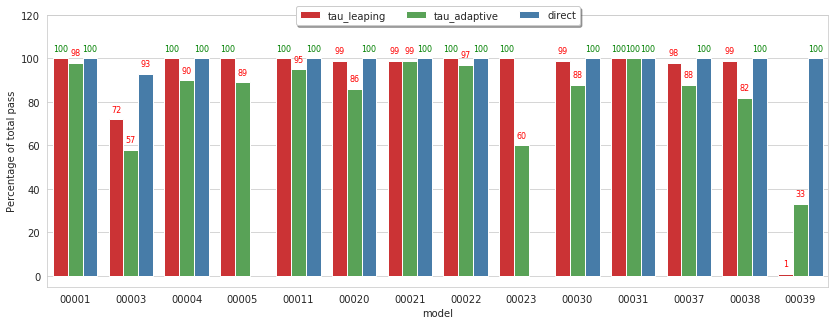

In [36]:
plot_accuracy_barplot(accuracy_results[accuracy_results.lib == "pyssa"])

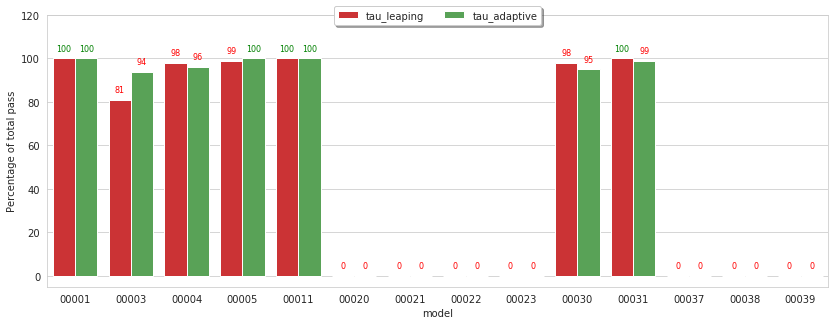

In [37]:
plot_accuracy_barplot(accuracy_results[accuracy_results.lib == "GillespieSSA"]) # tau = 0.1

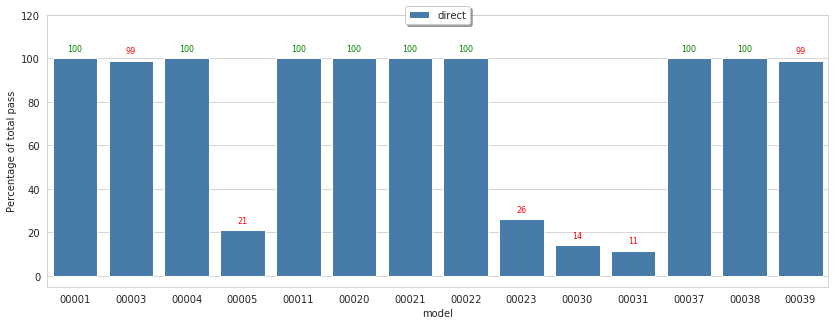

In [38]:
plot_accuracy_barplot(accuracy_results[accuracy_results.lib == "Tellurium"])

### Direct

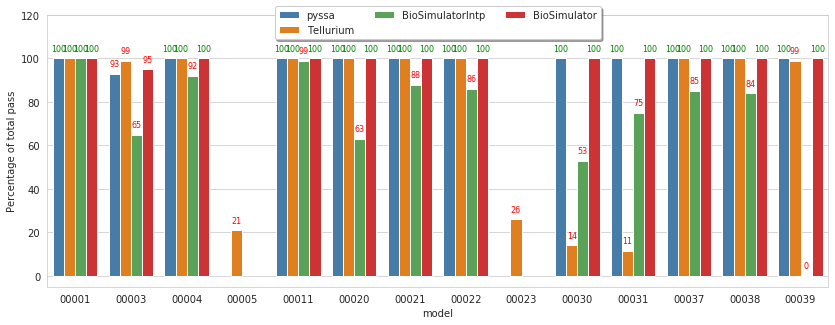

In [39]:
plot_accuracy_barplot(accuracy_results[accuracy_results.algo == "direct"], hue="lib")

Model | Fail | Reason
---|---|---
00001 | No | n/a
00003 | Yes, all | Even the C library says it will fail
00004 | Yes, BioSimulatorIntp | BioSimulatorIntp (BioSimulator internal interpolation not accurate)
00005 | DNF, all | Tellurium is probably not doing direct
00011 | No | n/a (99 is okay) 
00020 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00021 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00022 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00023 | DNF, all | Tellurium is probably not doing direct
00030 | Yes, Tellurium, BiosimulatorIntp | Tellurium fails even when rate expression is hardcoded as per `sbml-test-suite`. BiosimulatorIntp fails at high slope and low slope regions.
00031 | Yes, Tellurium, BiosimulatorIntp |  Tellurium fails even when rate expression is hardcoded as per `sbml-test-suite`. BiosimulatorIntp fails at high slope/quick change regions.
00037 | Yes, BiosimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00038 | Yes, BiosimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00039 | Yes, , BiosimulatorIntp | Fails completely because it returns an incorrect steady state.

# Tau leaping

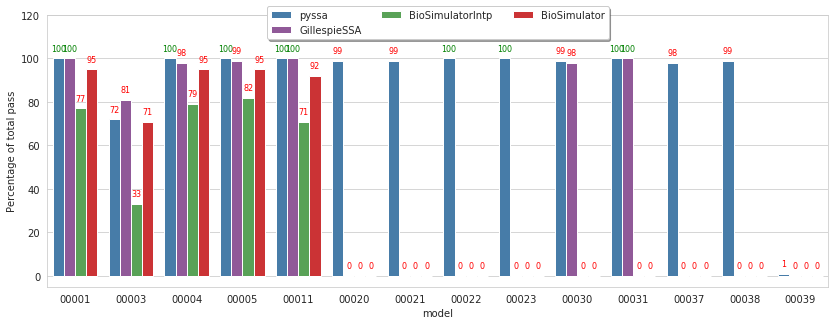

In [40]:
plot_accuracy_barplot(accuracy_results[accuracy_results.algo == "tau_leaping"], hue="lib")

Model | Fail | Reason
---|---|---
00001 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00003 | Yes, all | Even the C library says it will fail. BioSimulatorIntp is worse.
00004 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00005 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00011 | Yes, BioSimulatorIntp | BioSimulatorIntp accuracy fails at high slope/quick change regions
00020 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00021 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00022 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA  | All fail because of 0 species. 
00023 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA  | All fail because of 0 species.
00030 | Yes, Biosimulator, BiosimulatorIntp  | All fail because one species is 0.
00031 | Yes, Biosimulator, BiosimulatorIntp | All fail because one species is 0.
00037 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00038 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | All fail because of 0 species. 
00039 | Yes, all | Biosimulator, BiosimulatorIntp and GillespieSSA fails because of 0 species. `pyssa` fails, likely because of high tau. BioSimulator converges to the wrong mean value, but the model seems right (since it was copied and modified from 37, 38 and those converge to correct value. Strangely BioSimulator SD converges)

>NOTE:
>These results use $\mu$ and $\sigma$ ratios as the test statistic

# Tau adaptive

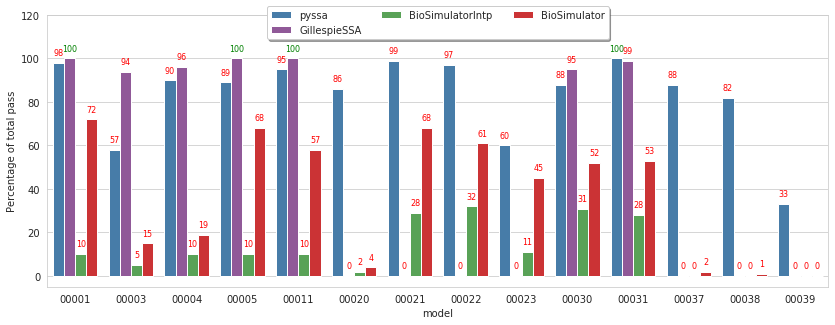

In [42]:
plot_accuracy_barplot(accuracy_results[accuracy_results.algo == "tau_adaptive"], hue="lib")

Model | Fail | Reason
---|---|---
00001 | Yes, Biosimulator and BiosimulatorIntp | SD (ratio) is lower than expected
00003 | Yes, pyssa, Biosimulator and BiosimulatorIntp | Mean and SD (ratios) are higher than expected
00004 | Yes, Biosimulator and BiosimulatorIntp | Mean is high and SD is lower than expected
00005 | Yes, Biosimulator and BiosimulatorIntp | SD is lower than expected
00011 | Yes, Biosimulator and BiosimulatorIntp | SD is lower than expected
00020 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | Gillespie fails because of 0 species. Mean and SD ratios are randomly fluctuating
00021 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | Gillespie fails because of 0 species. SD is higher than expected
00022 | Yes, Biosimulator, BiosimulatorIntp and GillespieSSA | Gillespie fails because of 0 species. SD is higher than expected
00023 | Yes, all | GillespieSSA fails because of 0 species. Deviation in mean and SD ratios.
00030 | Yes, pyssa, Biosimulator and BiosimulatorIntp | Deviation in mean and SD ratios.
00031 | Yes, Biosimulator and BiosimulatorIntp | High SD ratios.
00037 | Yes, all | GillespieSSA fails because of 0 species. Deviation in mean and SD ratios.
00038 | Yes, all | GillespieSSA fails because of 0 species. Deviation in mean and SD ratios.
00039 | Yes, all | GillespieSSA fails because of 0 species. Deviation in mean and SD ratios.

>NOTE:
>These results use $\mu$ and $\sigma$ ratios as the test statistic

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;overflow:hidden;
  padding:10px 5px;word-break:normal;}
.tg th{border-style:solid;border-width:0px;font-family:Arial, sans-serif;font-size:14px;font-weight:normal;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0lax{text-align:left;vertical-align:top}
.tg .tg-green{background-color:#c6e0b4;border-color:#000000;text-align:left;vertical-align:top}
.tg .tg-orange{background-color:#ffe685;border-color:#000000;text-align:left;vertical-align:top}
.tg .tg-73oq{border-color:#000000;text-align:left;vertical-align:top}
.tg .tg-red{background-color:#f4b084;border-color:#000000;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax"></th>
    <th class="tg-0lax">direct</th>
    <th class="tg-0lax">tau_leaping</th>
    <th class="tg-0lax">tau_adaptive</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">pyssa</td>
    <td class="tg-green">Most   accurate yet</td>
    <td class="tg-green">Very fast but may need manual tuning</td>
    <td class="tg-orange">Less   accurate than GillespieSSA's version</td>
  </tr>
  <tr>
    <td class="tg-0lax">Tellurium</td>
    <td class="tg-orange">Inaccurate   for 2nd order</td>
    <td class="tg-73oq">N/A</td>
    <td class="tg-73oq">N/A</td>
  </tr>
  <tr>
    <td class="tg-0lax">GillespieSSA</td>
    <td class="tg-orange">Very   slow</td>
    <td class="tg-red">Inaccurate   for initial zero counts</td>
    <td class="tg-red">Inaccurate   for initial zero counts</td>
  </tr>
  <tr>
    <td class="tg-0lax">BioSimulator.jl</td>
    <td class="tg-orange">Inaccurate   interpolation</td>
    <td class="tg-red">Inaccurate   for initial zero counts</td>
    <td class="tg-red">Inaccurate   for initial zero counts</td>
  </tr>
</tbody>
</table>

# Appendix
